<a href="https://colab.research.google.com/github/Chu-Yichen/QM2-Group-19/blob/main/MAIN_Data_Preparation%20%26%20Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Read and merge monitoring station information and filter sites in Atlanta by distance**

In [1]:
!pip install haversine folium

import pandas as pd
import numpy as np
import haversine
import requests
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import math

monitors = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/aqs_monitors.zip', converters={'State Code': str, 'County Code': str, 'Site Number': str})
monitors['Site Id'] = monitors['State Code'] + '-' + monitors['County Code'] + '-' + monitors['Site Number']
# Creates a unique ID for each site
monitors = monitors[monitors['Parameter Code'].isin([81102, 88101, 44201, 42401, 42101, 42602])]
"""
Extracting monitors that contain our desired pollutants (PM10, PM2.5, Ozone, SO2, NO2, CO)
Ozone (O3 - ppm): 44201
PM2.5 (µg/m3): 88101
PM10 (µg/m3): 81102
CO (ppm): 42101
SO2 (ppb): 42401
NO2 (ppb): 42602
"""

monitors['First Year of Data'] = pd.to_numeric(monitors['First Year of Data'], errors='coerce')
monitors['Last Sample Date'] = pd.to_datetime(monitors['Last Sample Date'], errors='coerce')

# Extract the 'year' part of the Last Sample Date column
monitors['Last Year'] = monitors['Last Sample Date'].dt.year
monitors['Fist Year'] = monitors['First Year of Data']


"""
Counties in the Atlanta region (with their FIPS codes): https://atlantaregional.org/about-arc/about-the-atlanta-region/

Cherokee: 057
Clayton: 063
Cobb: 067
DeKalb: 089
Douglas: 097
Fayette: 113
Forsyth: 117
Fulton: 121
Gwinnett: 135
Henry: 151
Rockdale: 247
"""

# Filter the monitors, only leave those with 6 pollutants data available from 1999 to 2024.
atl_counties = ['057','063','067','089','097','113','117','121','135','151','247']
monitors = monitors[(monitors['State Code'] == '13') & (monitors['County Code'].isin(atl_counties))]


site_locations = monitors[['Site Id', 'Latitude', 'Longitude']]
# Filter the dataframe by Site ID and co-ordinates
site_locations = site_locations.drop_duplicates()
site_locations = site_locations.dropna()
# Creates unique rows for each site and removes any sites that do not contain Latitudes and Longitudes
site_locations = site_locations.set_index('Site Id')

def get_site_distances_km(site_locations, lat, lng):
    site_distances = {}
    for site_id, site_row in site_locations.iterrows():
        site_distances[site_id] = haversine.haversine((lat, lng), (site_row['Latitude'], site_row['Longitude']))
    return site_distances
# A function that finds the distance between inputted co-ordinates and each site. This returns a dictionary of site number and distance.

distances = get_site_distances_km(site_locations, 33.6324, -84.4333)
# Co-ordinates for Hartsfield-Jackson Atlanta International Airport into our function.

nearby_site_ids = [site_id for site_id, distance in distances.items() if distance < 15]
# This retrieves all of the site IDs within a 15km radius from the airport.
all_site_ids = set(site_locations.index.tolist()) - set(nearby_site_ids)
# All eligible sites in Atlanta, excluding those within a 15km radius.

# Print the results
print("Monitors within 15 km of Atlanta Airport:")
print(set(nearby_site_ids))
nearby_site_ids_lsit = list(nearby_site_ids)
print(monitors[monitors['Site Id'].isin(nearby_site_ids)][['Site Id', 'Parameter Code', 'Parameter Name', 'First Year of Data', 'Last Sample Date']].dropna().groupby(['Parameter Code', 'Parameter Name']).agg({'First Year of Data': 'min', 'Last Sample Date': 'max'}))

print("\nOther monitors within the specified counties and time range:")
print(set(all_site_ids))
all_site_ids_list = list(all_site_ids)
print(monitors[monitors['Site Id'].isin(all_site_ids)][['Site Id', 'Parameter Code', 'Parameter Name', 'First Year of Data', 'Last Sample Date']].dropna().groupby(['Parameter Code', 'Parameter Name']).agg({'First Year of Data': 'min', 'Last Sample Date': 'max'}))

<ipython-input-1-009f4ebe8824>:12: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  monitors = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/aqs_monitors.zip', converters={'State Code': str, 'County Code': str, 'Site Number': str})
<ipython-input-1-009f4ebe8824>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monitors['First Year of Data'] = pd.to_numeric(monitors['First Year of Data'], errors='coerce')
<ipython-input-1-009f4ebe8824>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Monitors within 15 km of Atlanta Airport:
{'13-121-0031', '13-121-5001', '13-121-1001', '13-121-4001', '13-121-0043', '13-121-5002', '13-063-0091', '13-089-0002', '13-121-0001', '13-121-0041', '13-121-0053', '13-121-0055', '13-121-0002', '13-121-0047'}
                                         First Year of Data Last Sample Date
Parameter Code Parameter Name                                               
42101          Carbon monoxide                       1972.0       2024-10-31
42401          Sulfur dioxide                        1962.0       2024-10-31
42602          Nitrogen dioxide (NO2)                1972.0       2024-08-31
44201          Ozone                                 1974.0       2024-08-31
81102          PM10 Total 0-10um STP                 1993.0       2024-09-30
88101          PM2.5 - Local Conditions              1999.0       2024-09-30

Other monitors within the specified counties and time range:
{'13-057-0001', '13-121-0042', '13-067-0003', '13-121-0035', '13-089-

# **Sites on the map**

In [2]:
import folium

# Define the coordinates of the airport
airport_lat, airport_lng = 33.6324, -84.4333

# Create a Folium map centered at the airport with an adjustable zoom level
m = folium.Map(location=[airport_lat, airport_lng], zoom_start=10)

# Draw a 15 km radius circle around the airport to represent the 'nearby' zone
folium.Circle(
    location=[airport_lat, airport_lng],  # Center of the circle (airport location)
    radius=15000,  # Radius in meters
    color='red',
    fill=False,
    popup='15 km Radius'  # Tooltip that appears when the circle is clicked
).add_to(m)

# Add markers for 'nearby' sites (within 15 km of the airport)
for site_id in nearby_site_ids_lsit:
    # Get latitude and longitude of the site
    lat = site_locations.loc[site_id, 'Latitude']
    lon = site_locations.loc[site_id, 'Longitude']

    # Add a red marker for the site with a popup showing its ID
    folium.Marker(
        location=[lat, lon],  # Site location
        icon=folium.Icon(color='red', icon='info-sign'),  # Red icon for nearby sites
        popup=f"Nearby site: {site_id}"  # Popup text showing the site ID
    ).add_to(m)

# Add markers for 'other' sites (beyond 15 km from the airport)
for site_id in all_site_ids_list:
    # Get latitude and longitude of the site
    lat = site_locations.loc[site_id, 'Latitude']
    lon = site_locations.loc[site_id, 'Longitude']

    # Add a blue marker for the site with a popup showing its ID
    folium.Marker(
        location=[lat, lon],  # Site location
        icon=folium.Icon(color='blue', icon='info-sign'),  # Blue icon for other sites
        popup=f"Other site: {site_id}"  # Popup text showing the site ID
    ).add_to(m)

# Display the map
m


# **Visualisation for CO: (42101 Carbon Monoxide)**

Merge data

In [3]:
# For CO: Parameter Code 42101

years = range(1999, 2025)  # 1999 ~ 2024
urls = [f"https://aqs.epa.gov/aqsweb/airdata/daily_42101_{year}.zip" for year in years]

# our targeted sites = nearby + all
target_sites = nearby_site_ids_lsit + all_site_ids_list

all_data = []
for url in urls:
    df = pd.read_csv(url, compression='zip', low_memory=False)
    # Formatting
    df['State Code'] = df['State Code'].astype(str).str.zfill(2)
    df['County Code'] = df['County Code'].astype(str).str.zfill(3)
    df['Site Num'] = df['Site Num'].astype(str).str.zfill(4)
    df['Site Id'] = df['State Code'] + '-' + df['County Code'] + '-' + df['Site Num']
    df['Date Local'] = pd.to_datetime(df['Date Local'], errors='coerce')

    # Filter to only get the targeted sites
    df_target = df[df['Site Id'].isin(target_sites)]
    all_data.append(df_target)

# Merge each year's data
all_data = pd.concat(all_data, ignore_index=True)

# Extract the two sites' data respectively
df_nearby = all_data[all_data['Site Id'].isin(nearby_site_ids_lsit)].copy()
df_all = all_data[all_data['Site Id'].isin(all_site_ids_list)].copy()

# Extract daily data：in column 'Arithmetic Mean'

df_nearby_daily = df_nearby.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='CO_mean_nearby')
df_all_daily = df_all.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='CO_mean_all')



Visualisation: Daily Line Chart

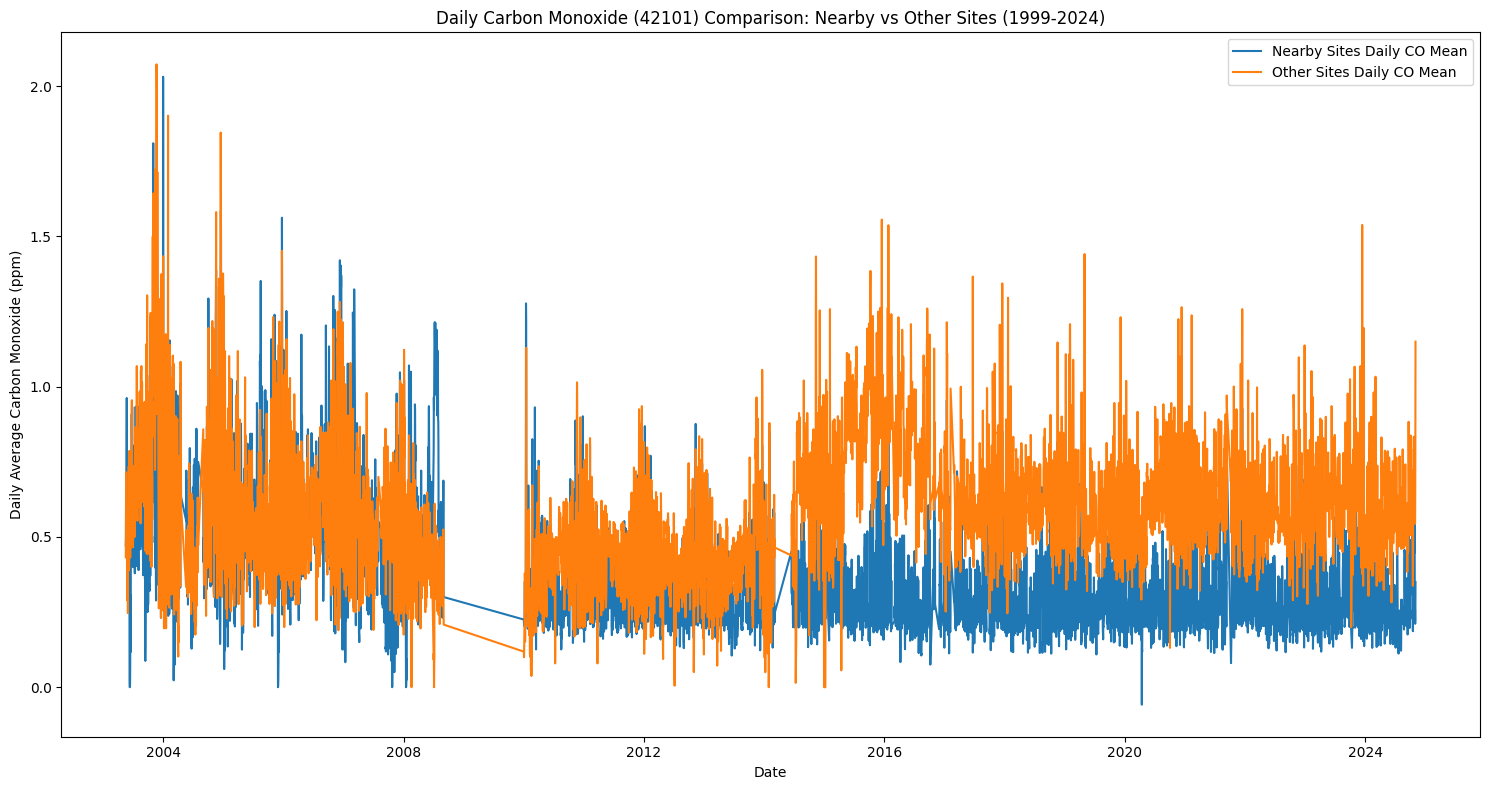

In [4]:
# Merge the two datasets to facilitate plotting
df_plot_daily = pd.merge(df_nearby_daily, df_all_daily, on='Date Local', how='inner')

plt.figure(figsize=(15,8))
sns.lineplot(x='Date Local', y='CO_mean_nearby', data=df_plot_daily, label='Nearby Sites Daily CO Mean')
sns.lineplot(x='Date Local', y='CO_mean_all', data=df_plot_daily, label='Other Sites Daily CO Mean')
plt.title('Daily Carbon Monoxide (42101) Comparison: Nearby vs Other Sites (1999-2024)')
plt.xlabel('Date')
plt.ylabel('Daily Average Carbon Monoxide (ppm)')
plt.legend()
plt.tight_layout()
plt.show()


Visualisation: Annual Line Chart

Annual mean for nearby sites:     year  CO_mean_nearby
0   2003        0.619581
1   2004        0.539882
2   2005        0.552392
3   2006        0.584739
4   2007        0.454229
5   2008        0.535013
6   2010        0.345722
7   2011        0.331725
8   2012        0.330369
9   2013        0.297181
10  2014        0.312784
11  2015        0.312534
12  2016        0.288075
13  2017        0.314071
14  2018        0.274388
15  2019        0.299879
16  2020        0.287023
17  2021        0.309095
18  2022        0.295341
19  2023        0.309950
20  2024        0.288543

Annual mean for other sites in Atlanta     year  CO_mean_all
0   1999     0.788291
1   2000     0.667080
2   2001     0.726662
3   2002     0.639245
4   2003     0.703118
5   2004     0.612018
6   2005     0.594946
7   2006     0.612632
8   2007     0.540168
9   2008     0.402264
10  2009     0.384094
11  2010     0.402237
12  2011     0.434499
13  2012     0.426481
14  2013     0.427839
15  2014     0.569084
16  20

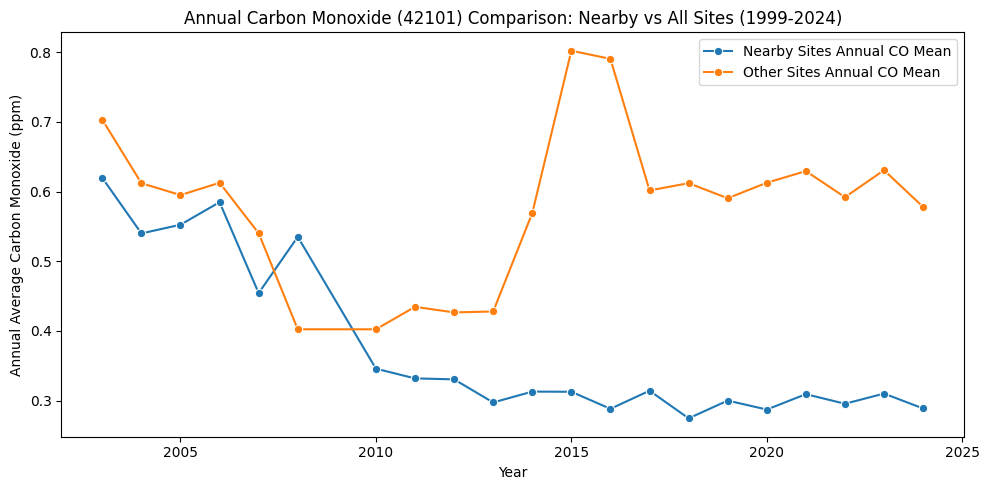

In [5]:
# Add a 'year' column to the daily data, extracting the year from the 'Date Local' column
df_nearby_daily['year'] = df_nearby_daily['Date Local'].dt.year
df_all_daily['year'] = df_all_daily['Date Local'].dt.year

# Group by 'year' and calculate the mean for each year
df_nearby_annual = df_nearby_daily.groupby('year')['CO_mean_nearby'].mean().reset_index()
df_all_annual = df_all_daily.groupby('year')['CO_mean_all'].mean().reset_index()


print("Annual mean for nearby sites:", df_nearby_annual)

print("\nAnnual mean for other sites in Atlanta", df_all_annual)

# Maybe looks a little bit messy but gives all the raw annual mean data

# Merge the two datasets on the 'year' column to facilitate plotting
df_plot_annual = pd.merge(df_nearby_annual, df_all_annual, on='year', how='inner')

# Create a line plot to compare the annual mean CO levels for nearby and other sites
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='CO_mean_nearby', data=df_plot_annual, marker='o', label='Nearby Sites Annual CO Mean')
sns.lineplot(x='year', y='CO_mean_all', data=df_plot_annual, marker='o', label='Other Sites Annual CO Mean')


plt.title('Annual Carbon Monoxide (42101) Comparison: Nearby vs All Sites (1999-2024)')
plt.xlabel('Year')
plt.ylabel('Annual Average Carbon Monoxide (ppm)')


plt.legend()
plt.tight_layout()
plt.show()


More Visualisation (Box Plot, Violin Plot)

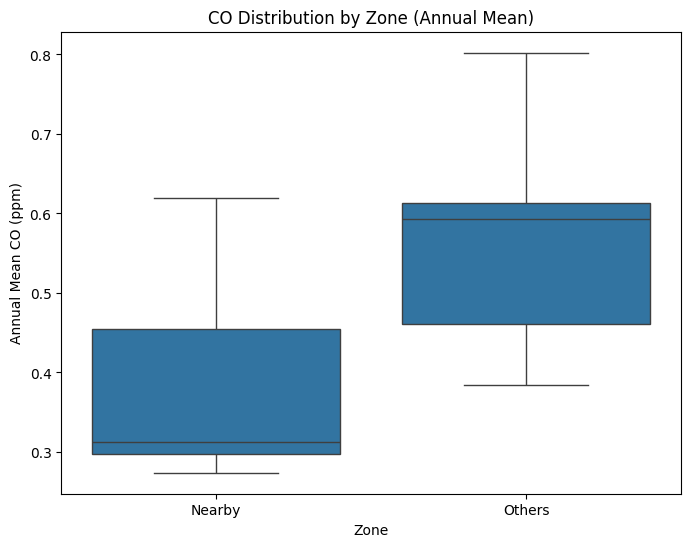

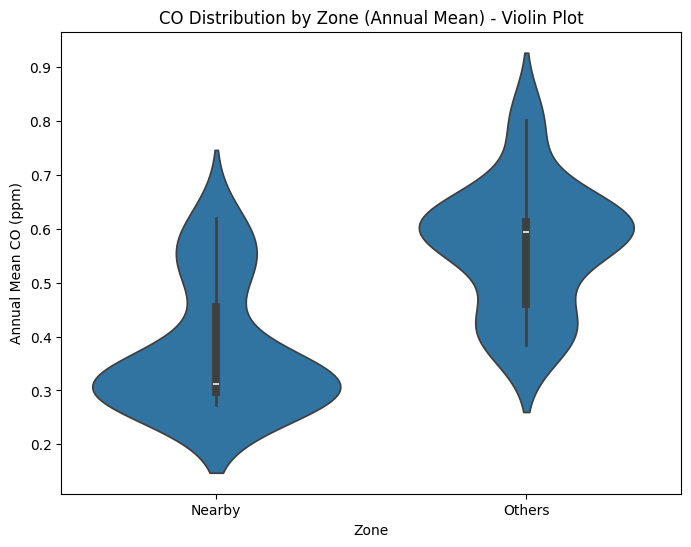

In [6]:
# Calculate annual mean CO for nearby sites
df_nearby_annual = df_nearby.copy()
df_nearby_annual['Year'] = df_nearby_annual['Date Local'].dt.year
df_nearby_annual = (
    df_nearby_annual.groupby('Year', as_index=False)['Arithmetic Mean']
    .mean()
    .rename(columns={'Arithmetic Mean': 'CO_annual_mean_nearby'})
)

# Calculate annual mean CO for all sites
df_all_annual = df_all.copy()
df_all_annual['Year'] = df_all_annual['Date Local'].dt.year
df_all_annual = (
    df_all_annual.groupby('Year', as_index=False)['Arithmetic Mean']
    .mean()
    .rename(columns={'Arithmetic Mean': 'CO_annual_mean_all'})
)

# Filter data for the years 2003 to 2024, as we don't get data from nearby sites before 2023
# REMOVE the filter dor other pollutants if they have enough data
df_nearby_annual = df_nearby_annual.loc[
    (df_nearby_annual['Year'] >= 2003) &
    (df_nearby_annual['Year'] <= 2024)
]
df_all_annual = df_all_annual.loc[
    (df_all_annual['Year'] >= 2003) &
    (df_all_annual['Year'] <= 2024)
]

# Prepare long-format data for visualization
df_nearby_long_annual = df_nearby_annual[['Year','CO_annual_mean_nearby']].rename(
    columns={'CO_annual_mean_nearby':'CO_annual_mean'}
)
df_nearby_long_annual['Zone'] = 'Nearby'

df_all_long_annual = df_all_annual[['Year','CO_annual_mean_all']].rename(
    columns={'CO_annual_mean_all':'CO_annual_mean'}
)
df_all_long_annual['Zone'] = 'Others'

# Combine nearby and all site data for visualization
df_annual_comparison = pd.concat([df_nearby_long_annual, df_all_long_annual], ignore_index=True)

# Create a box plot to compare annual mean CO distribution by zone
plt.figure(figsize=(8,6))
sns.boxplot(x='Zone', y='CO_annual_mean', data=df_annual_comparison)
plt.title('CO Distribution by Zone (Annual Mean)')
plt.ylabel('Annual Mean CO (ppm)')
plt.show()

# Create a violin plot to compare annual mean CO distribution by zone
plt.figure(figsize=(8,6))
sns.violinplot(x='Zone', y='CO_annual_mean', data=df_annual_comparison)
plt.title('CO Distribution by Zone (Annual Mean) - Violin Plot')
plt.ylabel('Annual Mean CO (ppm)')
plt.show()


Map & Graph : Spatial Analysis

In [7]:
!pip install basemap ipywidgets

from mpl_toolkits.basemap import Basemap  # For map visualization
import matplotlib.colors as mcolors  # For custom color scales
import ipywidgets as widgets  # For interactivity
from ipywidgets import interact  # For dynamic updates

# Add a 'Year' column to daily data
all_data['Year'] = all_data['Date Local'].dt.year

# Group data by 'Site Id' and 'Year', calculate annual average CO
df_siteyear = (
    all_data
    .groupby(['Site Id', 'Year'], as_index=False)['Arithmetic Mean']
    .mean()
    .rename(columns={'Arithmetic Mean': 'annual_CO'})
)

# Merge with site coordinates
site_locations_reset = site_locations.reset_index()
df_siteyear_merged = pd.merge(
    df_siteyear,
    site_locations_reset[['Site Id', 'Latitude', 'Longitude']],
    on='Site Id', how='inner'
)

# Clean data and define CO value range for color scaling
df_siteyear_merged.dropna(subset=['annual_CO', 'Latitude', 'Longitude'], inplace=True)
vmin, vmax = df_siteyear_merged['annual_CO'].min(), df_siteyear_merged['annual_CO'].max()

# Define custom color map (Green -> Yellow -> Red)
my_cmap = mcolors.LinearSegmentedColormap.from_list('CO_colormap', ['green', 'yellow', 'red'])

# Atlanta airport coordinates
airport_lat, airport_lng = 33.6367, -84.4281

# Function to plot map for a selected year
def plot_map_for_year(year):
    """Plot annual CO data for the given year."""
    df_year = df_siteyear_merged[df_siteyear_merged['Year'] == year]
    plt.figure(figsize=(8, 8))

    # Create Basemap focused on Atlanta
    m = Basemap(projection='lcc', resolution='l', lat_0=33.75, lon_0=-84.4, width=4e5, height=4e5)
    m.drawcoastlines(), m.drawcountries(), m.drawstates()

    # Mark airport location with a star
    x_airport, y_airport = m(airport_lng, airport_lat)
    m.plot(x_airport, y_airport, marker='*', color='black', markersize=14, label='ATL Airport')

    # Add 15 km radius circle
    m.tissot(airport_lng, airport_lat, 15 / 111.0, 100, facecolor='none', edgecolor='red', linewidth=2, alpha=0.8)

    # Plot CO levels for sites
    x, y = m(df_year['Longitude'].values, df_year['Latitude'].values)
    sc = m.scatter(x, y, c=df_year['annual_CO'], cmap=my_cmap, vmin=vmin, vmax=vmax, s=60, alpha=0.8, edgecolors='white', linewidths=0.5)

    # Add colorbar and title
    cbar = plt.colorbar(sc, orientation='vertical', shrink=0.7, pad=0.03)
    cbar.set_label('Annual Average CO (ppm)')
    plt.title(f"Annual CO in Atlanta Region - {year}")
    plt.legend(loc='lower left')
    plt.show()

# Create interactive dropdown for year selection
all_years = sorted(df_siteyear_merged['Year'].unique())
interact(
    plot_map_for_year,
    year=widgets.Dropdown(options=all_years, value=all_years[0], description='Select Year:')
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.0
    Uninstalling pyproj-3.7.0:
      Successfully uninstalled pyproj-3.7.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


interactive(children=(Dropdown(description='Select Year:', options=(1999, 2000, 2001, 2002, 2003, 2004, 2005, …

<function __main__.plot_map_for_year(year)>

# **Analysis & Hypothesis Testing for CO: (42101 Carbon Monoxide)**

** Correlation & Proximity Analysis**

Pearson correlation coefficient between 22-year average CO and distance (2003-2024): -0.0376, p-value: 0.9624
Spearman correlation coefficient between 22-year average CO and distance (2003-2024): 0.4000, p-value: 0.6


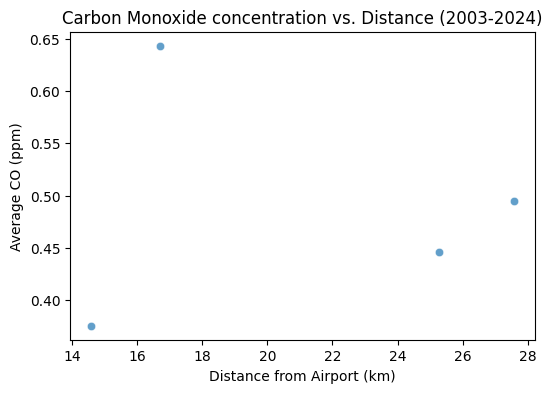

In [8]:
from scipy.stats import pearsonr, spearmanr

"""

Analyze the relationship between distance and CO concentration at the site level.

Instruction:
you can first calculate the CO concentration for a specific year (or multi-year average),
and then perform a correlation analysis with the site distances.
"""

# (1) Calculate the 22 year average CO for each site from 2003 to 2024 as an example.
#   You can adjust this to other time periods or focus only on one specific year.
df_22yr = df_siteyear[(df_siteyear['Year'] >= 2003) & (df_siteyear['Year'] <= 2024)]
df_22yr_avg = df_22yr.groupby('Site Id', as_index=False)['annual_CO'].mean().rename(columns={'annual_CO': 'co_22yr_mean'})

# (2) Merge with distance information
dist_df = pd.DataFrame(list(distances.items()), columns=['Site Id', 'distance_km'])
df_22yr_merged = pd.merge(df_22yr_avg, dist_df, on='Site Id', how='inner')

# (3) Perform correlation analysis
pearson_corr, pearson_pval = pearsonr(df_22yr_merged['distance_km'], df_22yr_merged['co_22yr_mean'])
spearman_corr, spearman_pval = spearmanr(df_22yr_merged['distance_km'], df_22yr_merged['co_22yr_mean'])

print(f"Pearson correlation coefficient between 22-year average CO and distance (2003-2024): {pearson_corr:.4f}, p-value: {pearson_pval:.4g}")
print(f"Spearman correlation coefficient between 22-year average CO and distance (2003-2024): {spearman_corr:.4f}, p-value: {spearman_pval:.4g}")

# Visualize scatter plot
plt.figure(figsize=(6,4))
sns.scatterplot(x='distance_km', y='co_22yr_mean', data=df_22yr_merged, alpha=0.7)
plt.xlabel('Distance from Airport (km)')
plt.ylabel('Average CO (ppm)')
plt.title('Carbon Monoxide concentration vs. Distance (2003-2024)')
plt.show()


Example intepretation based on the results:

1. **Pearson Correlation Coefficient**:
   - The Pearson correlation coefficient is **-0.6099**, suggesting a moderate negative linear relationship between distance from the airport and the 5-year average CO concentration.

   - The **p-value** is 0.1986, which is greater than 0.05. This indicates that the observed correlation is not statistically significant at the 95% confidence level.

2. **Spearman Correlation Coefficient**:
   - The Spearman correlation coefficient is **-0.2571**, suggesting a weak negative monotonic relationship between distance and CO concentration.
   - The **p-value** is 0.6228, also greater than 0.05, meaning the relationship is not statistically significant as well.

3. **Scatter Plot**:
   - The scatter plot shows some variability in CO concentrations with distance -- Not a strong trend suggesting a definitive relationship

**Interpretation:**
While there appears to be a negative correlation in the Pearson analysis, the lack of statistical significance (high p-values for both Pearson and Spearman tests) suggests that the relationship between distance and CO concentration cannot be reliably concluded.

**Preparation for hypothesis testing**

In [9]:
from scipy.stats import ttest_rel, ttest_ind

# Filter the data for the study period from 2003 to 2024 (should adjust the time period for other pollutants)
df_plot_daily['Year'] = df_plot_daily['Date Local'].dt.year
df_plot_daily_2 = df_plot_daily[
    (df_plot_daily['Year'] >= 2003) &
    (df_plot_daily['Year'] <= 2024)
].dropna(subset=['CO_mean_nearby', 'CO_mean_all']).copy()

print(f"After filtering 2003 to 2024, total records: {len(df_plot_daily_2)}")

After filtering 2003 to 2024, total records: 6927


**Hypothesis 1: Does proximity have an impact on air quality**

In [10]:
# Hypothesis 1: Near vs. Far (Paired t-test)
"""
H0: The mean daily CO concentration is the same for nearby and far sites.
H1: The mean daily CO concentration is different for the two groups.
(Using paired t-test, because each Date corresponds to a paired measurement:
 one from near sites, one from far sites, on the same day.)
"""

print("[Hypothesis 1] Paired t-test: near vs. far, daily CO from 2003 to 2024")

if len(df_plot_daily_2) < 2: # Check if we have enough data available
    print("Not enough daily paired records to perform t-test.")
else:
    # Prepare a DataFrame to display the CO values for nearby and far sites

    # print("Comparison of CO values:\n") (uncomment if you want to see the comparison)
    comparison_df = pd.DataFrame({
        'Date': df_plot_daily_2['Date Local'],
        'Nearby CO': df_plot_daily_2['CO_mean_nearby'],
        'Far CO': df_plot_daily_2['CO_mean_all']
    })
    # print(comparison_df.to_string(index=False))
    # uncomment if you want to see all the daily data comparison


    # Perform the paired t-test on the CO values
    t_stat, p_val = ttest_rel(
        df_plot_daily_2['CO_mean_nearby'],
        df_plot_daily_2['CO_mean_all']
    )
    print(f"\nT-statistic = {t_stat:.4f}, p-value = {p_val:.4g}")
    if p_val < 0.05: # Significant difference found, identify which group has higher mean CO
        print("=> Reject H0: There is a significant difference between Carbon Monoxide concentration near and far from the airport.")
        if df_plot_daily_2['CO_mean_nearby'].mean() > df_plot_daily_2['CO_mean_all'].mean():
            print("=> Nearby sites have higher daily CO on average.")
        else:
            print("=> Far sites have higher daily CO on average.")
    else:
        print("=> Fail to reject H0: No significant difference was found.")




[Hypothesis 1] Paired t-test: near vs. far, daily CO from 2003 to 2024

T-statistic = -76.9699, p-value = 0
=> Reject H0: There is a significant difference between Carbon Monoxide concentration near and far from the airport.
=> Far sites have higher daily CO on average.


**Hypothesis 2: Policy Effectiveness (Before vs. After Policy)**

In [11]:
"""
Assume that Year=2010 is the dividing line for policy implementation (can be adjusted to the actual year).
Here, 'CO_mean_nearby' is used as an example with an independent samples t-test (Welch’s t-test),
because 'a certain day in 2009' and 'a certain day in 2010' are not paired observations; they are two independent groups.

H0: The mean daily CO (nearby) is the same before and after the policy.
H1: The mean daily CO (nearby) is different before and after the policy.
"""

print("[Hypothesis 2] Policy effectiveness: before vs. after 2010 (nearby sites)")

# Split the data into two groups: before and after the policy implementation year (2010 here as an example)
before_policy = df_plot_daily_2.loc[df_plot_daily_2['Year'] < 2010, 'CO_mean_nearby']
after_policy  = df_plot_daily_2.loc[df_plot_daily_2['Year'] >= 2010, 'CO_mean_nearby']

# Perform Welch's t-test to compare the two groups
t_stat2, p_val2 = ttest_ind(before_policy, after_policy, equal_var=False)  # Welch’s t-test

# Output the test results
print(f"T-statistic = {t_stat2:.4f}, p-value = {p_val2:.4g}")
if p_val2 < 0.05:
    # Significant difference found
    print("=> Reject H0: There is a significant difference in near-site CO before vs. after 2010.")
    if after_policy.mean() < before_policy.mean(): # Evaluate policy effectiveness
        print("=> Policy to reduce emissions is effective: emissions significantly decreased after implementation.")
    else:
        print("=> Policy had an adverse effect: emissions significantly increased after implementation.")
else:
    # No significant difference found
    print("=> Fail to reject H0: No significant difference was found.")


[Hypothesis 2] Policy effectiveness: before vs. after 2010 (nearby sites)
T-statistic = 37.5059, p-value = 9.972e-238
=> Reject H0: There is a significant difference in near-site CO before vs. after 2010.
=> Policy to reduce emissions is effective: emissions significantly decreased after implementation.


# Visualisation for NO2: (42602 Nitrogen Dioxide)

Merge data

In [12]:
# For NO2: Parameter Code 42602

years = range(1999, 2025)  # 1999 ~ 2024
urls = [f"https://aqs.epa.gov/aqsweb/airdata/daily_42602_{year}.zip" for year in years]

# our targeted sites = nearby + all
target_sites = nearby_site_ids_lsit + all_site_ids_list

all_data = []
for url in urls:
    df = pd.read_csv(url, compression='zip', low_memory=False)
    # Formatting
    df['State Code'] = df['State Code'].astype(str).str.zfill(2)
    df['County Code'] = df['County Code'].astype(str).str.zfill(3)
    df['Site Num'] = df['Site Num'].astype(str).str.zfill(4)
    df['Site Id'] = df['State Code'] + '-' + df['County Code'] + '-' + df['Site Num']
    df['Date Local'] = pd.to_datetime(df['Date Local'], errors='coerce')

    # Filter to only get the targeted sites
    df_target = df[df['Site Id'].isin(target_sites)]
    all_data.append(df_target)

# Merge each year's data
all_data = pd.concat(all_data, ignore_index=True)

# Extract the two sites' data respectively
df_nearby = all_data[all_data['Site Id'].isin(nearby_site_ids_lsit)].copy()
df_all = all_data[all_data['Site Id'].isin(all_site_ids_list)].copy()

# Extract daily data：in column 'Arithmetic Mean'

df_nearby_daily = df_nearby.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='NO2_mean_nearby')
df_all_daily = df_all.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='NO2_mean_all')



Visualisation: Daily Line Chart

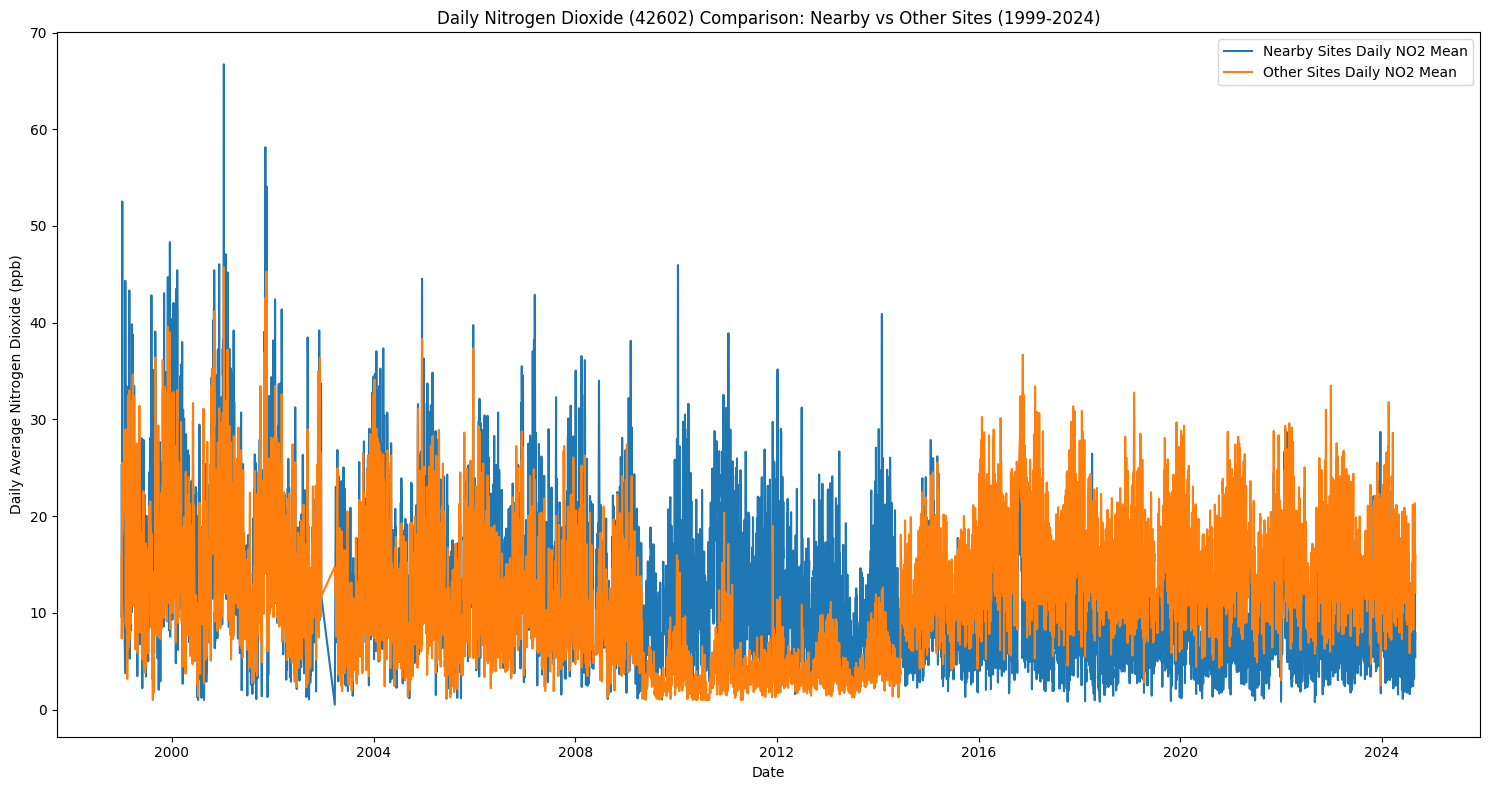

In [ ]:
# Merge the two datasets to facilitate plotting
df_plot_daily = pd.merge(df_nearby_daily, df_all_daily, on='Date Local', how='inner')

plt.figure(figsize=(15,8))
sns.lineplot(x='Date Local', y='NO2_mean_nearby', data=df_plot_daily, label='Nearby Sites Daily NO2 Mean')
sns.lineplot(x='Date Local', y='NO2_mean_all', data=df_plot_daily, label='Other Sites Daily NO2 Mean')
plt.title('Daily Nitrogen Dioxide (42602) Comparison: Nearby vs Other Sites (1999-2024)')
plt.xlabel('Date')
plt.ylabel('Daily Average Nitrogen Dioxide (ppb)')
plt.legend()
plt.tight_layout()
plt.show()


Visualisation: Annual Line Chart

Annual mean for nearby sites:     year  NO2_mean_nearby
0   1999        19.574671
1   2000        18.115519
2   2001        17.604957
3   2002        14.837293
4   2003        13.353029
5   2004        14.768332
6   2005        14.419249
7   2006        15.485776
8   2007        14.588113
9   2008        13.112769
10  2009        10.665184
11  2010        13.670129
12  2011        13.427384
13  2012        11.575723
14  2013         9.342422
15  2014        10.513340
16  2015         9.741747
17  2016        10.530328
18  2017         8.666324
19  2018         7.780222
20  2019         9.310074
21  2020         7.552704
22  2021         8.227148
23  2022         8.799568
24  2023         9.125296
25  2024         8.528464

Annual mean for other sites in Atlanta     year  NO2_mean_all
0   1999     16.274486
1   2000     15.698248
2   2001     15.886951
3   2002     14.070215
4   2003     12.526104
5   2004     12.625835
6   2005     12.533622
7   2006     12.000102
8   2007     11.01833

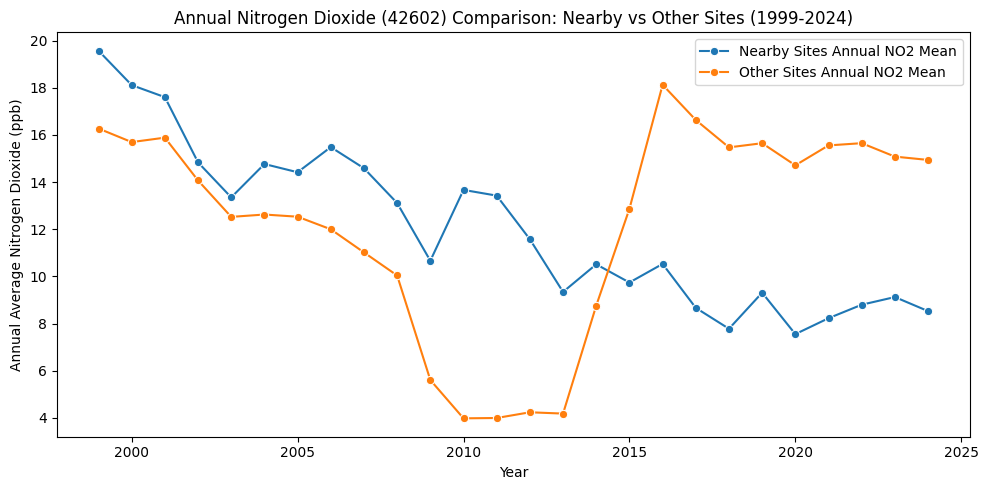

In [13]:
# Add a 'year' column to the daily data, extracting the year from the 'Date Local' column
df_nearby_daily['year'] = df_nearby_daily['Date Local'].dt.year
df_all_daily['year'] = df_all_daily['Date Local'].dt.year

# Group by 'year' and calculate the mean for each year
df_nearby_annual = df_nearby_daily.groupby('year')['NO2_mean_nearby'].mean().reset_index()
df_all_annual = df_all_daily.groupby('year')['NO2_mean_all'].mean().reset_index()


print("Annual mean for nearby sites:", df_nearby_annual)

print("\nAnnual mean for other sites in Atlanta", df_all_annual)

# Maybe looks a little bit messy but gives all the raw annual mean data

# Merge the two datasets on the 'year' column to facilitate plotting
df_plot_annual = pd.merge(df_nearby_annual, df_all_annual, on='year', how='inner')

# Create a line plot to compare the annual mean CO levels for nearby and other sites
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='NO2_mean_nearby', data=df_plot_annual, marker='o', label='Nearby Sites Annual NO2 Mean')
sns.lineplot(x='year', y='NO2_mean_all', data=df_plot_annual, marker='o', label='Other Sites Annual NO2 Mean')


plt.title('Annual Nitrogen Dioxide (42602) Comparison: Nearby vs Other Sites (1999-2024)')
plt.xlabel('Year')
plt.ylabel('Annual Average Nitrogen Dioxide (ppb)')


plt.legend()
plt.tight_layout()
plt.show()


More Visualisation (Box Plot, Violin Plot)

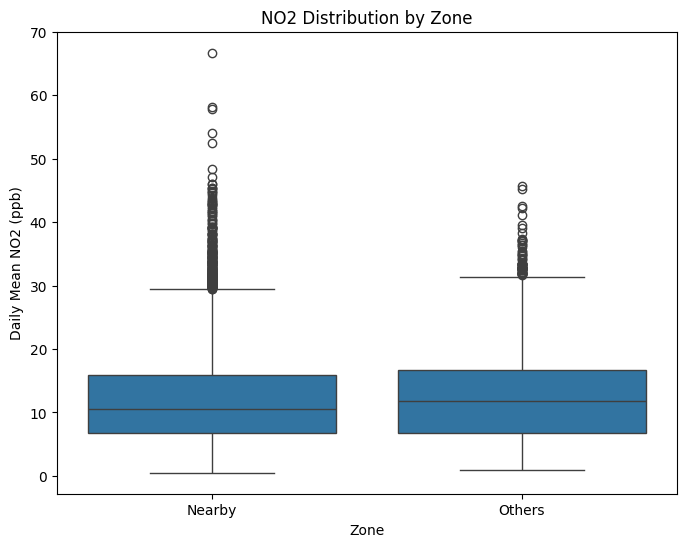

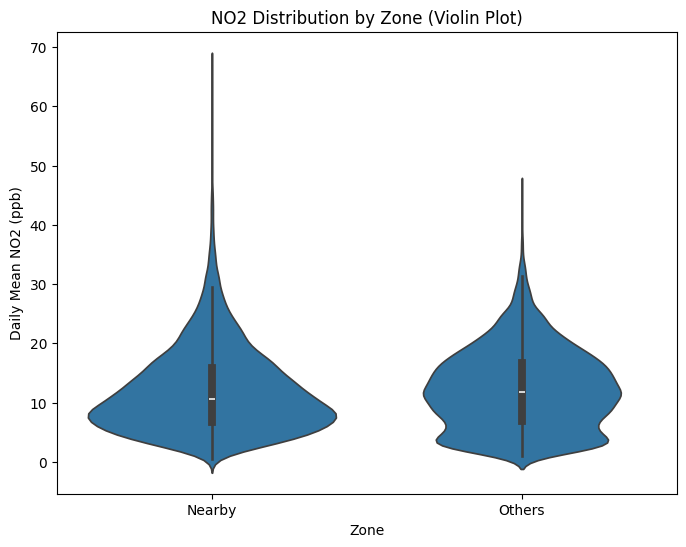

In [14]:
# Construct long-format data for visualization
df_nearby_long = df_nearby_daily[['Date Local', 'NO2_mean_nearby']].rename(columns={'NO2_mean_nearby': 'NO2_mean'})
df_nearby_long['Zone'] = 'Nearby'  # Label the 'Nearby' zone

df_all_long = df_all_daily[['Date Local', 'NO2_mean_all']].rename(columns={'NO2_mean_all': 'NO2_mean'})
df_all_long['Zone'] = 'Others'  # Label the 'Others' zone

# Combine the two datasets into one for comparison
df_daily_comparison = pd.concat([df_nearby_long, df_all_long], ignore_index=True)

# Create a box plot to compare the distribution of daily mean CO between the two zones
plt.figure(figsize=(8,6))
sns.boxplot(x='Zone', y='NO2_mean', data=df_daily_comparison)
plt.title('NO2 Distribution by Zone')  # Set the title for the box plot
plt.ylabel('Daily Mean NO2 (ppb)')  # Label the y-axis
plt.show()

# Create a violin plot to further visualize the distribution of daily mean CO
plt.figure(figsize=(8,6))
sns.violinplot(x='Zone', y='NO2_mean', data=df_daily_comparison)
plt.title('NO2 Distribution by Zone (Violin Plot)')  # Set the title for the violin plot
plt.ylabel('Daily Mean NO2 (ppb)')  # Label the y-axis
plt.show()


Map & Graph: Spacial Data Analysis

In [16]:
!pip install basemap ipywidgets

from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors


import ipywidgets as widgets
from ipywidgets import interact


# Example: all_data should include at least the following columns:
# ['Site Id', 'Date Local', 'Arithmetic Mean', ...]

# Ensure 'Date Local' is in datetime format
all_data['Year'] = all_data['Date Local'].dt.year

# Group by Site Id and Year, then calculate the mean
df_siteyear = (
    all_data
    .groupby(['Site Id','Year'], as_index=False)['Arithmetic Mean']
    .mean()
    .rename(columns={'Arithmetic Mean':'annual_NO2'})
)

# Merge with site_locations to include Latitude and Longitude
site_locations_reset = site_locations.reset_index()  # ['Site Id','Latitude','Longitude']
df_siteyear_merged = pd.merge(
    df_siteyear,
    site_locations_reset[['Site Id','Latitude','Longitude']],
    on='Site Id',
    how='inner'
)

# Remove invalid records
df_siteyear_merged.dropna(subset=['annual_NO2','Latitude','Longitude'], inplace=True)

# Define the global color scale range for uniform visualization
vmin = df_siteyear_merged['annual_NO2'].min()
vmax = df_siteyear_merged['annual_NO2'].max()

# Create a custom color map (Green -> Yellow -> Red)
my_cmap = mcolors.LinearSegmentedColormap.from_list(
    'NO2_colormap',
    ['green','yellow','red']
)

# ATL airport coordinates
airport_lat, airport_lng = 33.6367, -84.4281


# (2) Function to plot the map for a specific year

def plot_map_for_year(year):
    """Plot the annual average CO data for a specific year on a Basemap."""
    df_year = df_siteyear_merged[df_siteyear_merged['Year'] == year]

    plt.figure(figsize=(8,8))

    # Create the Basemap with Lambert Conformal projection
    m = Basemap(
        projection='lcc',
        resolution='l',
        lat_0=33.75,      # Center the map near ATL
        lon_0=-84.4,
        width=4e5,
        height=4e5
    )

    # Draw map boundaries and features
    m.drawcoastlines(color='black')
    m.drawcountries(color='black')
    m.drawstates(color='gray')

    # Mark the ATL airport with a star
    x_airport, y_airport = m(airport_lng, airport_lat)
    m.plot(
        x_airport, y_airport,
        marker='*',
        color='black',
        markersize=14,
        label='ATL Airport'
    )

       # Add 15 km radius circle
    m.tissot(airport_lng, airport_lat, 15 / 111.0, 100, facecolor='none', edgecolor='red', linewidth=2, alpha=0.8)

    # Scatter plot for the CO data points of the selected year
    x, y = m(df_year['Longitude'].values, df_year['Latitude'].values)
    sc = m.scatter(
        x, y,
        c=df_year['annual_NO2'],
        cmap=my_cmap,
        vmin=vmin,
        vmax=vmax,
        s=60,
        alpha=0.8,
        edgecolors='white',
        linewidths=0.5
    )

    # Add a colorbar
    cbar = plt.colorbar(sc, orientation='vertical', shrink=0.7, pad=0.03)
    cbar.set_label('Annual Average NO2 (ppb)', fontsize=12)

    # Add title and legend
    plt.title(f"Annual NO2 in Atlanta Region - {year}", fontsize=14)
    plt.legend(loc='lower left')
    plt.show()


# (3) Interactive year selection

all_years = sorted(df_siteyear_merged['Year'].unique())

# Use interact for year selection
interact(
    plot_map_for_year,
    year=widgets.Dropdown(
        options=all_years,
        value=all_years[0],
        description='Select Year:'
    )
)


interactive(children=(Dropdown(description='Select Year:', options=(1999, 2000, 2001, 2002, 2003, 2004, 2005, …

<function __main__.plot_map_for_year(year)>

# Analysis & Hypothesis Testing for NO2: (42602 Nitrogen Dioxide)

Correlation & Proximity Analysis

Pearson correlation coefficient between 22-year average NO2 and distance (2003-2024): -0.6099, p-value: 0.1986
Spearman correlation coefficient between 22-year average NO2 and distance (2003-2024): -0.2571, p-value: 0.6228


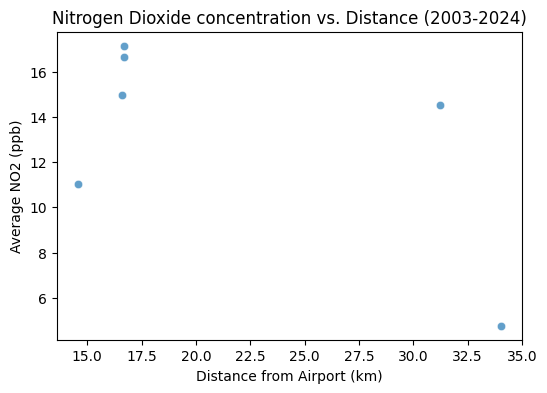

In [17]:
from scipy.stats import pearsonr, spearmanr

"""

Analyze the relationship between distance and CO concentration at the site level.

Instruction:
you can first calculate the CO concentration for a specific year (or multi-year average),
and then perform a correlation analysis with the site distances.
"""

# (1) Calculate the 22 year average CO for each site from 2003 to 2024 as an example.
#   You can adjust this to other time periods or focus only on one specific year.
df_22yr = df_siteyear[(df_siteyear['Year'] >= 2003) & (df_siteyear['Year'] <= 2024)]
df_22yr_avg = df_22yr.groupby('Site Id', as_index=False)['annual_NO2'].mean().rename(columns={'annual_NO2': 'no2_22yr_mean'})

# (2) Merge with distance information
dist_df = pd.DataFrame(list(distances.items()), columns=['Site Id', 'distance_km'])
df_22yr_merged = pd.merge(df_22yr_avg, dist_df, on='Site Id', how='inner')

# (3) Perform correlation analysis
pearson_corr, pearson_pval = pearsonr(df_22yr_merged['distance_km'], df_22yr_merged['no2_22yr_mean'])
spearman_corr, spearman_pval = spearmanr(df_22yr_merged['distance_km'], df_22yr_merged['no2_22yr_mean'])

print(f"Pearson correlation coefficient between 22-year average NO2 and distance (2003-2024): {pearson_corr:.4f}, p-value: {pearson_pval:.4g}")
print(f"Spearman correlation coefficient between 22-year average NO2 and distance (2003-2024): {spearman_corr:.4f}, p-value: {spearman_pval:.4g}")

# Visualize scatter plot
plt.figure(figsize=(6,4))
sns.scatterplot(x='distance_km', y='no2_22yr_mean', data=df_22yr_merged, alpha=0.7)
plt.xlabel('Distance from Airport (km)')
plt.ylabel('Average NO2 (ppb)')
plt.title('Nitrogen Dioxide concentration vs. Distance (2003-2024)')
plt.show()


Preparation for hypothesis testing

In [19]:
from scipy.stats import ttest_rel, ttest_ind

# Filter the data for the study period from 2003 to 2024 (should adjust the time period for other pollutants)
df_plot_daily['Year'] = df_plot_daily['Date Local'].dt.year
df_plot_daily_2 = df_plot_daily[
    (df_plot_daily['Year'] >= 2003) &
    (df_plot_daily['Year'] <= 2024)
].dropna(subset=['NO2_mean_nearby', 'NO2_mean_all']).copy()

print(f"After filtering 2003 to 2024, total records: {len(df_plot_daily_2)}")

KeyError: ['NO2_mean_nearby', 'NO2_mean_all']

Hypothesis 1: Does proximity have an impact on air quality

In [20]:
# Hypothesis 1: Near vs. Far (Paired t-test)
"""
H0: The mean daily NO2 concentration is the same for nearby and far sites.
H1: The mean daily NO2 concentration is different for the two groups.
(Using paired t-test, because each Date corresponds to a paired measurement:
 one from near sites, one from far sites, on the same day.)
"""

print("[Hypothesis 1] Paired t-test: near vs. far, daily NO2 from 2003 to 2024")

if len(df_plot_daily_2) < 2: # Check if we have enough data available
    print("Not enough daily paired records to perform t-test.")
else:
    # Prepare a DataFrame to display the CO values for nearby and far sites

    # print("Comparison of CO values:\n") (uncomment if you want to see the comparison)
    comparison_df = pd.DataFrame({
        'Date': df_plot_daily_2['Date Local'],
        'Nearby NO2': df_plot_daily_2['NO2_mean_nearby'],
        'Far NO2': df_plot_daily_2['NO2_mean_all']
    })
    # print(comparison_df.to_string(index=False))
    # uncomment if you want to see all the daily data comparison


    # Perform the paired t-test on the CO values
    t_stat, p_val = ttest_rel(
        df_plot_daily_2['NO2_mean_nearby'],
        df_plot_daily_2['NO2_mean_all']
    )
    print(f"\nT-statistic = {t_stat:.4f}, p-value = {p_val:.4g}")
    if p_val < 0.05: # Significant difference found, identify which group has higher mean CO
        print("=> Reject H0: There is a significant difference between Nitrogen Dioxide concentration near and far from the airport.")
        if df_plot_daily_2['NO2_mean_nearby'].mean() > df_plot_daily_2['NO2_mean_all'].mean():
            print("=> Nearby sites have higher daily NO2 on average.")
        else:
            print("=> Far sites have higher daily NO2 on average.")
    else:
        print("=> Fail to reject H0: No significant difference was found.")




[Hypothesis 1] Paired t-test: near vs. far, daily NO2 from 2003 to 2024


KeyError: 'NO2_mean_nearby'

Hypothesis 2: Policy Effectiveness (Before vs. After Policy)

In [ ]:
"""
Assume that Year=2010 is the dividing line for policy implementation (can be adjusted to the actual year).
Here, 'CO_mean_nearby' is used as an example with an independent samples t-test (Welch’s t-test),
because 'a certain day in 2009' and 'a certain day in 2010' are not paired observations; they are two independent groups.

H0: The mean daily NO2 (nearby) is the same before and after the policy.
H1: The mean daily NO2 (nearby) is different before and after the policy.
"""

print("[Hypothesis 2] Policy effectiveness: before vs. after 2010 (nearby sites)")

# Split the data into two groups: before and after the policy implementation year (2010 here as an example)
before_policy = df_plot_daily_2.loc[df_plot_daily_2['Year'] < 2010, 'NO2_mean_nearby']
after_policy  = df_plot_daily_2.loc[df_plot_daily_2['Year'] >= 2010, 'NO2_mean_nearby']

# Perform Welch's t-test to compare the two groups
t_stat2, p_val2 = ttest_ind(before_policy, after_policy, equal_var=False)  # Welch’s t-test

# Output the test results
print(f"T-statistic = {t_stat2:.4f}, p-value = {p_val2:.4g}")
if p_val2 < 0.05:
    # Significant difference found
    print("=> Reject H0: There is a significant difference in near-site NO2 before vs. after 2010.")
    if after_policy.mean() < before_policy.mean(): # Evaluate policy effectiveness
        print("=> Policy to reduce emissions is effective: emissions significantly decreased after implementation.")
    else:
        print("=> Policy had an adverse effect: emissions significantly increased after implementation.")
else:
    # No significant difference found
    print("=> Fail to reject H0: No significant difference was found.")


# Visualisation for SO2:(42401 Sulfur Dioxide)

Merge data

In [21]:
# For SO2: Parameter Code 42401

years = range(1999, 2025)  # 1999 ~ 2024
urls = [f"https://aqs.epa.gov/aqsweb/airdata/daily_42401_{year}.zip" for year in years]

# our targeted sites = nearby + all
target_sites = nearby_site_ids_lsit + all_site_ids_list

all_data = []
for url in urls:
    df = pd.read_csv(url, compression='zip', low_memory=False)
    # Formatting
    df['State Code'] = df['State Code'].astype(str).str.zfill(2)
    df['County Code'] = df['County Code'].astype(str).str.zfill(3)
    df['Site Num'] = df['Site Num'].astype(str).str.zfill(4)
    df['Site Id'] = df['State Code'] + '-' + df['County Code'] + '-' + df['Site Num']
    df['Date Local'] = pd.to_datetime(df['Date Local'], errors='coerce')

    # Filter to only get the targeted sites
    df_target = df[df['Site Id'].isin(target_sites)]
    all_data.append(df_target)

# Merge each year's data
all_data = pd.concat(all_data, ignore_index=True)

# Extract the two sites' data respectively
df_nearby = all_data[all_data['Site Id'].isin(nearby_site_ids_lsit)].copy()
df_all = all_data[all_data['Site Id'].isin(all_site_ids_list)].copy()

# Extract daily data：in column 'Arithmetic Mean'

df_nearby_daily = df_nearby.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='SO2_mean_nearby')
df_all_daily = df_all.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='SO2_mean_all')



Visualisation: Daily Line Chart

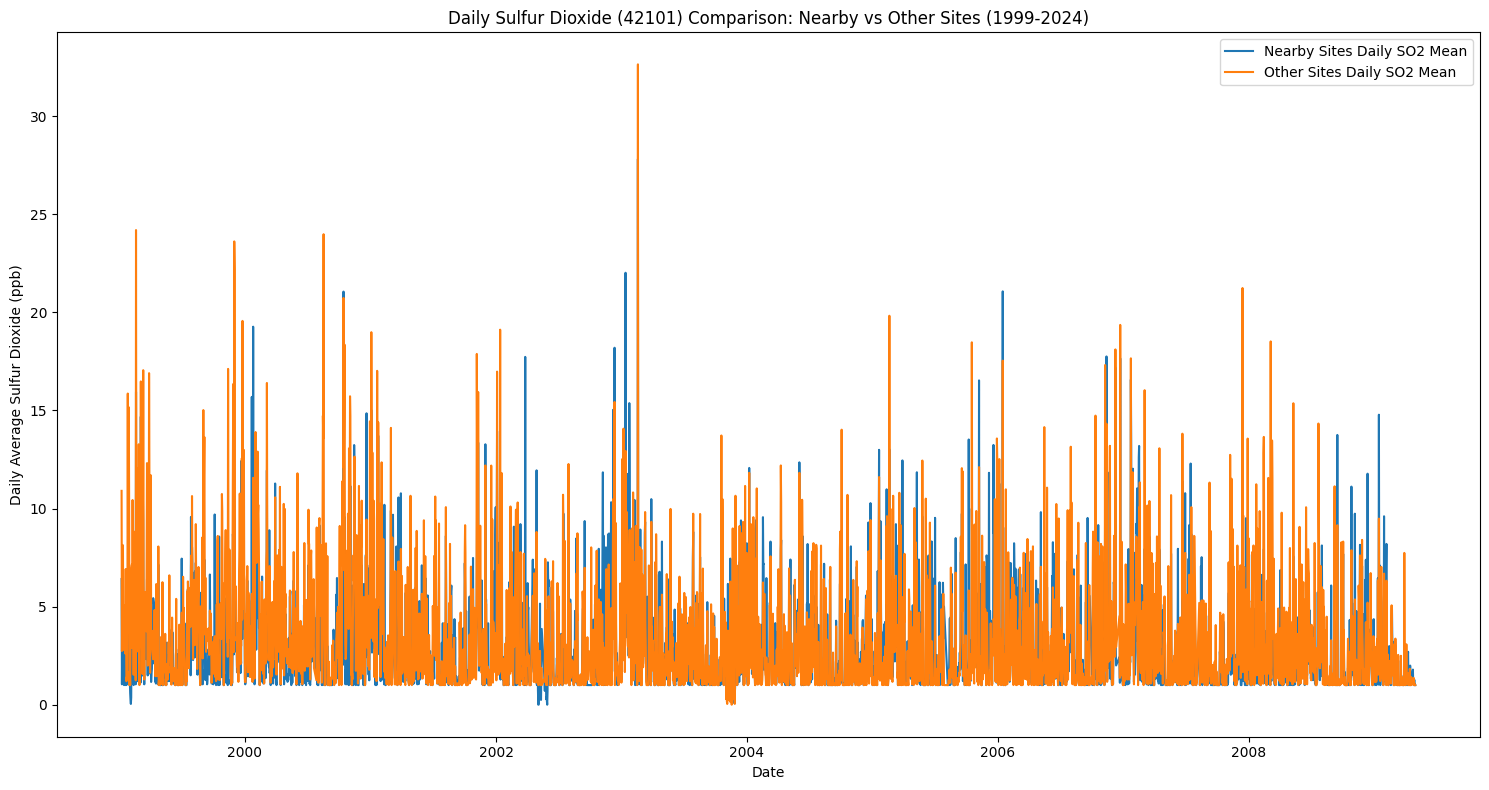

In [22]:
# Merge the two datasets to facilitate plotting
df_plot_daily = pd.merge(df_nearby_daily, df_all_daily, on='Date Local', how='inner')

plt.figure(figsize=(15,8))
sns.lineplot(x='Date Local', y='SO2_mean_nearby', data=df_plot_daily, label='Nearby Sites Daily SO2 Mean')
sns.lineplot(x='Date Local', y='SO2_mean_all', data=df_plot_daily, label='Other Sites Daily SO2 Mean')
plt.title('Daily Sulfur Dioxide (42101) Comparison: Nearby vs Other Sites (1999-2024)')
plt.xlabel('Date')
plt.ylabel('Daily Average Sulfur Dioxide (ppb)')
plt.legend()
plt.tight_layout()
plt.show()

Visualisation: Annual Line Chart

Annual mean for nearby sites:     year  SO2_mean_nearby
0   1999         2.977601
1   2000         3.165780
2   2001         3.066835
3   2002         2.953800
4   2003         2.953509
5   2004         2.822379
6   2005         3.171264
7   2006         3.330261
8   2007         2.727056
9   2008         2.538345
10  2009         1.667974
11  2010         1.791071
12  2011         1.295318
13  2012         0.774651
14  2013         0.693597
15  2014         0.706915
16  2015         0.601192
17  2016         0.639935
18  2017         0.661815
19  2018         0.452916
20  2019         0.622629
21  2020         0.487757
22  2021         0.614417
23  2022         0.424063
24  2023         0.917232
25  2024         0.623726

Annual mean for other sites in Atlanta     year  SO2_mean_all
0   1999      4.592986
1   2000      4.606565
2   2001      3.370936
3   2002      2.933396
4   2003      3.239307
5   2004      2.772856
6   2005      3.016621
7   2006      3.406831
8   2007      3.38005

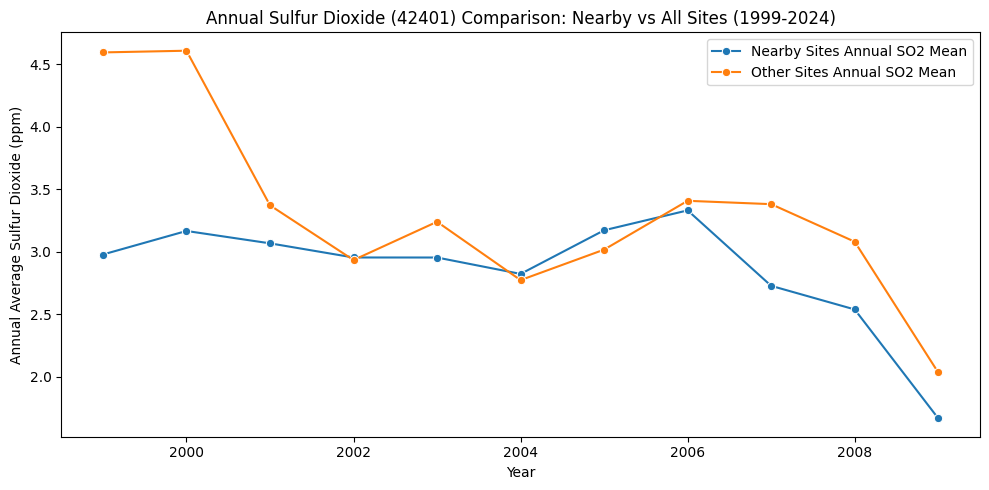

In [23]:
# Add a 'year' column to the daily data, extracting the year from the 'Date Local' column
df_nearby_daily['year'] = df_nearby_daily['Date Local'].dt.year
df_all_daily['year'] = df_all_daily['Date Local'].dt.year

# Group by 'year' and calculate the mean for each year
df_nearby_annual = df_nearby_daily.groupby('year')['SO2_mean_nearby'].mean().reset_index()
df_all_annual = df_all_daily.groupby('year')['SO2_mean_all'].mean().reset_index()


print("Annual mean for nearby sites:", df_nearby_annual)

print("\nAnnual mean for other sites in Atlanta", df_all_annual)

# Maybe looks a little bit messy but gives all the raw annual mean data

# Merge the two datasets on the 'year' column to facilitate plotting
df_plot_annual = pd.merge(df_nearby_annual, df_all_annual, on='year', how='inner')

# Create a line plot to compare the annual mean CO levels for nearby and other sites
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='SO2_mean_nearby', data=df_plot_annual, marker='o', label='Nearby Sites Annual SO2 Mean')
sns.lineplot(x='year', y='SO2_mean_all', data=df_plot_annual, marker='o', label='Other Sites Annual SO2 Mean')


plt.title('Annual Sulfur Dioxide (42401) Comparison: Nearby vs All Sites (1999-2024)')
plt.xlabel('Year')
plt.ylabel('Annual Average Sulfur Dioxide (ppm)')


plt.legend()
plt.tight_layout()
plt.show()


More visualisation(Box Plot, Violin Plot)

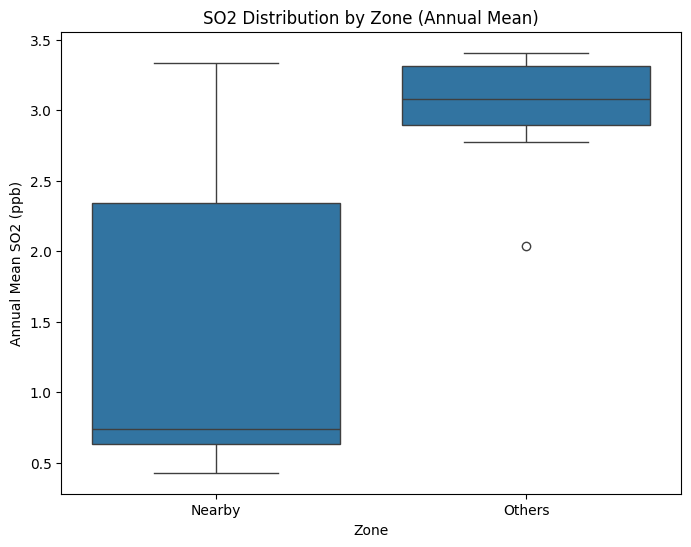

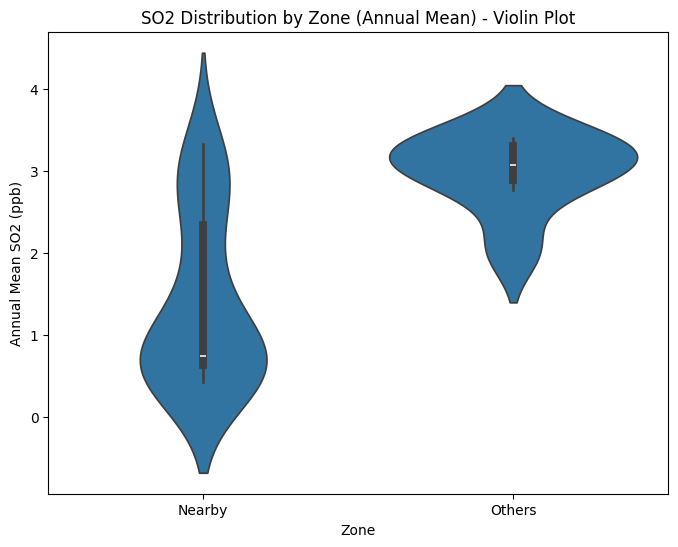

In [24]:
# Calculate annual mean CO for nearby sites
df_nearby_annual = df_nearby.copy()
df_nearby_annual['Year'] = df_nearby_annual['Date Local'].dt.year
df_nearby_annual = (
    df_nearby_annual.groupby('Year', as_index=False)['Arithmetic Mean']
    .mean()
    .rename(columns={'Arithmetic Mean': 'SO2_annual_mean_nearby'})
)

# Calculate annual mean CO for all sites
df_all_annual = df_all.copy()
df_all_annual['Year'] = df_all_annual['Date Local'].dt.year
df_all_annual = (
    df_all_annual.groupby('Year', as_index=False)['Arithmetic Mean']
    .mean()
    .rename(columns={'Arithmetic Mean': 'SO2_annual_mean_all'})
)

# Filter data for the years 2003 to 2024, as we don't get data from nearby sites before 2023
# REMOVE the filter dor other pollutants if they have enough data
df_nearby_annual = df_nearby_annual.loc[
    (df_nearby_annual['Year'] >= 2003) &
    (df_nearby_annual['Year'] <= 2024)
]
df_all_annual = df_all_annual.loc[
    (df_all_annual['Year'] >= 2003) &
    (df_all_annual['Year'] <= 2024)
]

# Prepare long-format data for visualization
df_nearby_long_annual = df_nearby_annual[['Year','SO2_annual_mean_nearby']].rename(
    columns={'SO2_annual_mean_nearby':'SO2_annual_mean'}
)
df_nearby_long_annual['Zone'] = 'Nearby'

df_all_long_annual = df_all_annual[['Year','SO2_annual_mean_all']].rename(
    columns={'SO2_annual_mean_all':'SO2_annual_mean'}
)
df_all_long_annual['Zone'] = 'Others'

# Combine nearby and all site data for visualization
df_annual_comparison = pd.concat([df_nearby_long_annual, df_all_long_annual], ignore_index=True)

# Create a box plot to compare annual mean CO distribution by zone
plt.figure(figsize=(8,6))
sns.boxplot(x='Zone', y='SO2_annual_mean', data=df_annual_comparison)
plt.title('SO2 Distribution by Zone (Annual Mean)')
plt.ylabel('Annual Mean SO2 (ppb)')
plt.show()

# Create a violin plot to compare annual mean CO distribution by zone
plt.figure(figsize=(8,6))
sns.violinplot(x='Zone', y='SO2_annual_mean', data=df_annual_comparison)
plt.title('SO2 Distribution by Zone (Annual Mean) - Violin Plot')
plt.ylabel('Annual Mean SO2 (ppb)')
plt.show()


Map & Graph: Spatial Analysis

In [25]:
!pip install basemap ipywidgets

from mpl_toolkits.basemap import Basemap  # For map visualization
import matplotlib.colors as mcolors  # For custom color scales
import ipywidgets as widgets  # For interactivity
from ipywidgets import interact  # For dynamic updates

# Add a 'Year' column to daily data
all_data['Year'] = all_data['Date Local'].dt.year

# Group data by 'Site Id' and 'Year', calculate annual average CO
df_siteyear = (
    all_data
    .groupby(['Site Id', 'Year'], as_index=False)['Arithmetic Mean']
    .mean()
    .rename(columns={'Arithmetic Mean': 'annual_SO2'})
)

# Merge with site coordinates
site_locations_reset = site_locations.reset_index()
df_siteyear_merged = pd.merge(
    df_siteyear,
    site_locations_reset[['Site Id', 'Latitude', 'Longitude']],
    on='Site Id', how='inner'
)

# Clean data and define CO value range for color scaling
df_siteyear_merged.dropna(subset=['annual_SO2', 'Latitude', 'Longitude'], inplace=True)
vmin, vmax = df_siteyear_merged['annual_SO2'].min(), df_siteyear_merged['annual_SO2'].max()

# Define custom color map (Green -> Yellow -> Red)
my_cmap = mcolors.LinearSegmentedColormap.from_list('SO2_colormap', ['green', 'yellow', 'red'])

# Atlanta airport coordinates
airport_lat, airport_lng = 33.6367, -84.4281

# Function to plot map for a selected year
def plot_map_for_year(year):
    """Plot annual SO2 data for the given year."""
    df_year = df_siteyear_merged[df_siteyear_merged['Year'] == year]
    plt.figure(figsize=(8, 8))

    # Create Basemap focused on Atlanta
    m = Basemap(projection='lcc', resolution='l', lat_0=33.75, lon_0=-84.4, width=4e5, height=4e5)
    m.drawcoastlines(), m.drawcountries(), m.drawstates()

    # Mark airport location with a star
    x_airport, y_airport = m(airport_lng, airport_lat)
    m.plot(x_airport, y_airport, marker='*', color='black', markersize=14, label='ATL Airport')

    # Add 15 km radius circle
    m.tissot(airport_lng, airport_lat, 15 / 111.0, 100, facecolor='none', edgecolor='red', linewidth=2, alpha=0.8)

    # Plot CO levels for sites
    x, y = m(df_year['Longitude'].values, df_year['Latitude'].values)
    sc = m.scatter(x, y, c=df_year['annual_SO2'], cmap=my_cmap, vmin=vmin, vmax=vmax, s=60, alpha=0.8, edgecolors='white', linewidths=0.5)

    # Add colorbar and title
    cbar = plt.colorbar(sc, orientation='vertical', shrink=0.7, pad=0.03)
    cbar.set_label('Annual Average SO2 (ppb)')
    plt.title(f"Annual SO2 in Atlanta Region - {year}")
    plt.legend(loc='lower left')
    plt.show()

# Create interactive dropdown for year selection
all_years = sorted(df_siteyear_merged['Year'].unique())
interact(
    plot_map_for_year,
    year=widgets.Dropdown(options=all_years, value=all_years[0], description='Select Year:')
)


interactive(children=(Dropdown(description='Select Year:', options=(1999, 2000, 2001, 2002, 2003, 2004, 2005, …

<function __main__.plot_map_for_year(year)>

# Analysis & Hypothesis Testing for SO2: (42401 Sulfur Dioxide)

Correlation & Proximity Analysis

Pearson correlation coefficient between 22-year average SO2 and distance (2003-2024): 0.4328, p-value: 0.715
Spearman correlation coefficient between 22-year average SO2 and distance (2003-2024): 0.5000, p-value: 0.6667


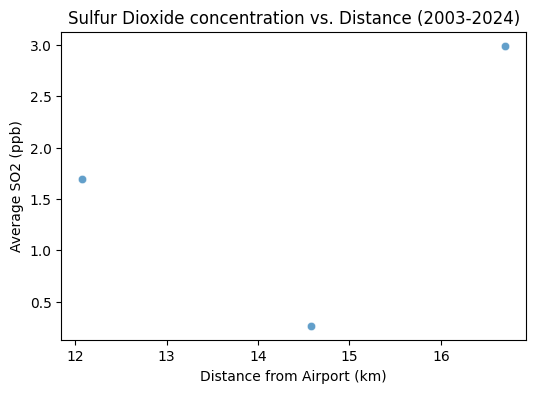

In [26]:
from scipy.stats import pearsonr, spearmanr

"""

Analyze the relationship between distance and CO concentration at the site level.

Instruction:
you can first calculate the CO concentration for a specific year (or multi-year average),
and then perform a correlation analysis with the site distances.
"""

# (1) Calculate the 22 year average CO for each site from 2003 to 2024 as an example.
#   You can adjust this to other time periods or focus only on one specific year.
df_22yr = df_siteyear[(df_siteyear['Year'] >= 2003) & (df_siteyear['Year'] <= 2024)]
df_22yr_avg = df_22yr.groupby('Site Id', as_index=False)['annual_SO2'].mean().rename(columns={'annual_SO2': 'so2_22yr_mean'})

# (2) Merge with distance information
dist_df = pd.DataFrame(list(distances.items()), columns=['Site Id', 'distance_km'])
df_22yr_merged = pd.merge(df_22yr_avg, dist_df, on='Site Id', how='inner')

# (3) Perform correlation analysis
pearson_corr, pearson_pval = pearsonr(df_22yr_merged['distance_km'], df_22yr_merged['so2_22yr_mean'])
spearman_corr, spearman_pval = spearmanr(df_22yr_merged['distance_km'], df_22yr_merged['so2_22yr_mean'])

print(f"Pearson correlation coefficient between 22-year average SO2 and distance (2003-2024): {pearson_corr:.4f}, p-value: {pearson_pval:.4g}")
print(f"Spearman correlation coefficient between 22-year average SO2 and distance (2003-2024): {spearman_corr:.4f}, p-value: {spearman_pval:.4g}")

# Visualize scatter plot
plt.figure(figsize=(6,4))
sns.scatterplot(x='distance_km', y='so2_22yr_mean', data=df_22yr_merged, alpha=0.7)
plt.xlabel('Distance from Airport (km)')
plt.ylabel('Average SO2 (ppb)')
plt.title('Sulfur Dioxide concentration vs. Distance (2003-2024)')
plt.show()


Preparation for hypothesis testing

In [27]:
from scipy.stats import ttest_rel, ttest_ind

# Filter the data for the study period from 2003 to 2024 (should adjust the time period for other pollutants)
df_plot_daily['Year'] = df_plot_daily['Date Local'].dt.year
df_plot_daily_2 = df_plot_daily[
    (df_plot_daily['Year'] >= 2003) &
    (df_plot_daily['Year'] <= 2024)
].dropna(subset=['SO2_mean_nearby', 'SO2_mean_all']).copy()

print(f"After filtering 2003 to 2024, total records: {len(df_plot_daily_2)}")

After filtering 2003 to 2024, total records: 2273


Hypothesis 1: Does proximity have an impact on air quality

In [28]:
# Hypothesis 1: Near vs. Far (Paired t-test)
"""
H0: The mean daily SO2 concentration is the same for nearby and far sites.
H1: The mean daily SO2 concentration is different for the two groups.
(Using paired t-test, because each Date corresponds to a paired measurement:
 one from near sites, one from far sites, on the same day.)
"""

print("[Hypothesis 1] Paired t-test: near vs. far, daily SO2 from 2003 to 2024")

if len(df_plot_daily_2) < 2: # Check if we have enough data available
    print("Not enough daily paired records to perform t-test.")
else:
    # Prepare a DataFrame to display the CO values for nearby and far sites

    # print("Comparison of CO values:\n") (uncomment if you want to see the comparison)
    comparison_df = pd.DataFrame({
        'Date': df_plot_daily_2['Date Local'],
        'Nearby SO2': df_plot_daily_2['SO2_mean_nearby'],
        'Far SO2': df_plot_daily_2['SO2_mean_all']
    })
    # print(comparison_df.to_string(index=False))
    # uncomment if you want to see all the daily data comparison


    # Perform the paired t-test on the CO values
    t_stat, p_val = ttest_rel(
        df_plot_daily_2['SO2_mean_nearby'],
        df_plot_daily_2['SO2_mean_all']
    )
    print(f"\nT-statistic = {t_stat:.4f}, p-value = {p_val:.4g}")
    if p_val < 0.05: # Significant difference found, identify which group has higher mean CO
        print("=> Reject H0: There is a significant difference between Sulfur Dioxide concentration near and far from the airport.")
        if df_plot_daily_2['SO2_mean_nearby'].mean() > df_plot_daily_2['SO2_mean_all'].mean():
            print("=> Nearby sites have higher daily SO2 on average.")
        else:
            print("=> Far sites have higher daily SO2 on average.")
    else:
        print("=> Fail to reject H0: No significant difference was found.")




[Hypothesis 1] Paired t-test: near vs. far, daily SO2 from 2003 to 2024

T-statistic = -4.5787, p-value = 4.932e-06
=> Reject H0: There is a significant difference between Sulfur Dioxide concentration near and far from the airport.
=> Far sites have higher daily SO2 on average.


Hypothesis 2: Policy Effectiveness (Before vs. After Policy)

In [29]:
"""
Assume that Year=2010 is the dividing line for policy implementation (can be adjusted to the actual year).
Here, 'CO_mean_nearby' is used as an example with an independent samples t-test (Welch’s t-test),
because 'a certain day in 2009' and 'a certain day in 2010' are not paired observations; they are two independent groups.

H0: The mean daily SO2 (nearby) is the same before and after the policy.
H1: The mean daily SO2 (nearby) is different before and after the policy.
"""

print("[Hypothesis 2] Policy effectiveness: before vs. after 2010 (nearby sites)")

# Split the data into two groups: before and after the policy implementation year (2010 here as an example)
before_policy = df_plot_daily_2.loc[df_plot_daily_2['Year'] < 2010, 'SO2_mean_nearby']
after_policy  = df_plot_daily_2.loc[df_plot_daily_2['Year'] >= 2010, 'SO2_mean_nearby']

# Perform Welch's t-test to compare the two groups
t_stat2, p_val2 = ttest_ind(before_policy, after_policy, equal_var=False)  # Welch’s t-test

# Output the test results
print(f"T-statistic = {t_stat2:.4f}, p-value = {p_val2:.4g}")
if p_val2 < 0.05:
    # Significant difference found
    print("=> Reject H0: There is a significant difference in near-site SO2 before vs. after 2010.")
    if after_policy.mean() < before_policy.mean(): # Evaluate policy effectiveness
        print("=> Policy to reduce emissions is effective: emissions significantly decreased after implementation.")
    else:
        print("=> Policy had an adverse effect: emissions significantly increased after implementation.")
else:
    # No significant difference found
    print("=> Fail to reject H0: No significant difference was found.")


[Hypothesis 2] Policy effectiveness: before vs. after 2010 (nearby sites)
T-statistic = nan, p-value = nan
=> Fail to reject H0: No significant difference was found.
